In [1]:
import torch 

import sys
import os
sys.path.insert(0, os.getcwd())

from shapenet_pytorch import ShapeNetDataset
from lsm import LSM
from vis_tools import *

from IPython.display import display
from IPython.core.display import HTML

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nvox = 32
batch_size = 20
nviews = 4

In [2]:
def show_results(test_dataset, class_name):
    imgs, vol, K, R = test_dataset[0]
    imgs_tensor = torch.Tensor(imgs).to(device)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    K = torch.Tensor(K).to(device)
    R = torch.Tensor(R).to(device)
    
    lsm = LSM(device)
    sd = torch.load('./checkpoints/experiment_{}/best_model.pth'.format(class_name), map_location='cuda:0')
    if 'image_enc.conv_bn1.running_var' in sd.keys():
        lsm.load_state_dict(sd)
        with torch.no_grad():
            vol_pred = lsm(imgs_tensor, K, R)
            vol_pred = vol_pred.squeeze()
            vol_pred = vol_pred.cpu().numpy()
            pts, cols = voxel2pts(vol_pred)
        pts_true, cols_true = voxel2pts(vol)
        display(plot_points(pts, cols, size=0.4, axis=False, title="Predicted", html_out='predict/3D/eval_{}.html'.format(class_name)))
        display(plot_points(pts_true, cols_true, size=0.4, axis=False, title="Ground Truth", html_out='true/3D/true_{}.html'.format(class_name)))
        plot_images(imgs, '{}.png'.format(class_name))
    else:
        print("bn model missing for {}".format(class_name))

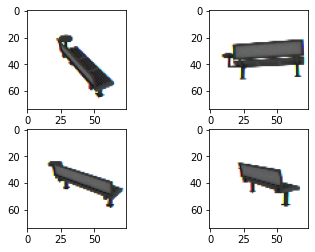

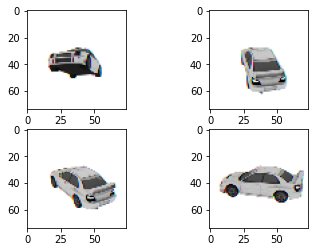

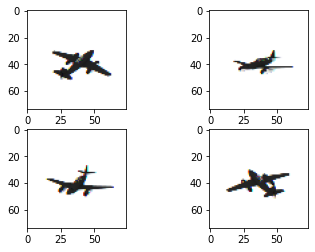

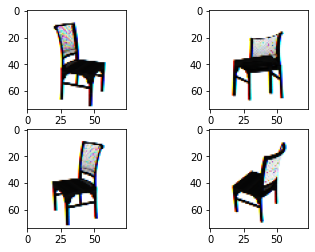

In [3]:
classes = ['bench', 'car', 'airplane', 'chair']
vox_dir = './shapenet_sample/voxels/modelVoxels32/'
im_dir = './shapenet_sample/renders/'
split_file = './shapenet_sample/splits_sample.json'

for c in classes:
    categories = [c]
    test_dataset = ShapeNetDataset(im_dir, vox_dir, nviews, nvox, split_file, train=False, categories=categories)
    show_results(test_dataset, c)